In [12]:
# unzip dataset_letras.zip
!unzip dataset_letras_final.zip

Archive:  dataset_letras_final.zip
replace dataset_letras3/A/A_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset_letras3/A/A_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset_letras3/A/A_10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
!pip install wandb

In [13]:
import wandb

## Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

## Inicializa WandB
wandb.init(project="repte1_psiv", entity="andreu-mir")

wandb: Currently logged in as: andreu-mir (xisca). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1. Arquitectura model

In [20]:
import torch
import torch.nn as nn
from torchvision import models

# Cargar ResNet-18 preentrenada y ajustarla para imágenes en escala de grises
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()

        # Cargar el modelo ResNet-18 preentrenado
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modificar la primera capa convolucional para aceptar imágenes con 1 canal (grayscale)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modificar la última capa fully connected (fc) para 26 clases en lugar de 1000
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 26)

    def forward(self, x):
        return self.resnet(x)

# Crear una instancia del modelo
model = ResNetModel()


# 2. Dataset

In [16]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar WandB
wandb.init(project="letra_recognition_RESNET")

# Definición de parámetros
batch_size = 32
img_height, img_width = 64, 40  # Tamaño de las imágenes

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Redimensionar las imágenes
    transforms.Grayscale(num_output_channels=1),  # Asegurarse de que la imagen sea en escala de grises
    transforms.ToTensor(),  # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,)),  # Normalizar las imágenes (grayscale)
])

# Cargar el dataset
base_dir = 'dataset_letras3'
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Número de pliegues para la validación cruzada
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Verificación
print(f"Total dataset size: {len(dataset)}")

Total dataset size: 13000


# 3. Train Model

In [17]:
import torch.nn as nn
import torch.optim as optim

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# see shape of dataset_letras\0\0_0.png

print(dataset[0][0].shape)

torch.Size([1, 64, 40])


Fold 1/5
Epoch [1/20], Loss: 3.5166, Accuracy: 0.0432
Epoch [2/20], Loss: 3.5184, Accuracy: 0.0433
Epoch [3/20], Loss: 3.5118, Accuracy: 0.0457
Epoch [4/20], Loss: 3.5163, Accuracy: 0.0475
Epoch [5/20], Loss: 3.5132, Accuracy: 0.0466
Epoch [6/20], Loss: 3.5146, Accuracy: 0.0447
Epoch [7/20], Loss: 3.5157, Accuracy: 0.0454
Epoch [8/20], Loss: 3.5254, Accuracy: 0.0462
Epoch [9/20], Loss: 3.5129, Accuracy: 0.0476
Epoch [10/20], Loss: 3.5179, Accuracy: 0.0451
Epoch [11/20], Loss: 3.5178, Accuracy: 0.0434
Epoch [12/20], Loss: 3.5122, Accuracy: 0.0455
Epoch [13/20], Loss: 3.5191, Accuracy: 0.0474
Epoch [14/20], Loss: 3.5133, Accuracy: 0.0474
Epoch [15/20], Loss: 3.5188, Accuracy: 0.0486
Epoch [16/20], Loss: 3.5121, Accuracy: 0.0445
Epoch [17/20], Loss: 3.5155, Accuracy: 0.0437
Epoch [18/20], Loss: 3.5170, Accuracy: 0.0431
Epoch [19/20], Loss: 3.5207, Accuracy: 0.0468
Epoch [20/20], Loss: 3.5067, Accuracy: 0.0488


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 3.5657, Validation Accuracy: 0.0438
Validation Precision: 0.0487
Validation Recall: 0.0438
Validation F1 Score: 0.0383
Confusion Matrix:
[[ 0  2  1  1  0  0  3  0  0  0  0  0  0  1  1 20 35  1  1 24  0  0  0  2
   0  1]
 [ 0  0  0  1  0  0  0  0  1  0  0  0  2  1 23 38  3  1 21  1  0  1  0  3
   1  0]
 [14  0  0 18  1  0  1  0  0  0  1  0  1  2 43  3  4  0  3  3  0  3  2  3
   0  0]
 [ 0  0  0 46  1  0  0  0  0  1  0  0  0  0  4  2  1  0  1 38  0  1  0  6
   0  1]
 [ 0  1  0  0  0  0  1  0  0  0  0  0  0  2  1  1 45  0  1 44  0  2  0  3
   0  0]
 [ 0  0  0  0  0  0  3  0  0  0  1  0  1  1  0  2  2  0 45  2  0  2  0 34
   0  0]
 [ 0  0  0  2  0  0  3  0  0  0  1  0  0  3  3 44  1  0  0  1  0  0  1  4
  42  0]
 [18  0  1  1  0  0  1  0  0  0  0  0  1  3 16  2  6  0  0  5  0 49  0  1
   0  0]
 [ 1  0  0 37  0  0  2  0  0  0  0  0  0  1  0  0  3  0  1  1  0  3  0 51
   0  0]
 [ 1  0  0  2  0  0  0  0  0  0  0  0  1  1  0  2 44  0  3  0  0  1  1 42
   0  0]
 [ 0 37  0  1  0

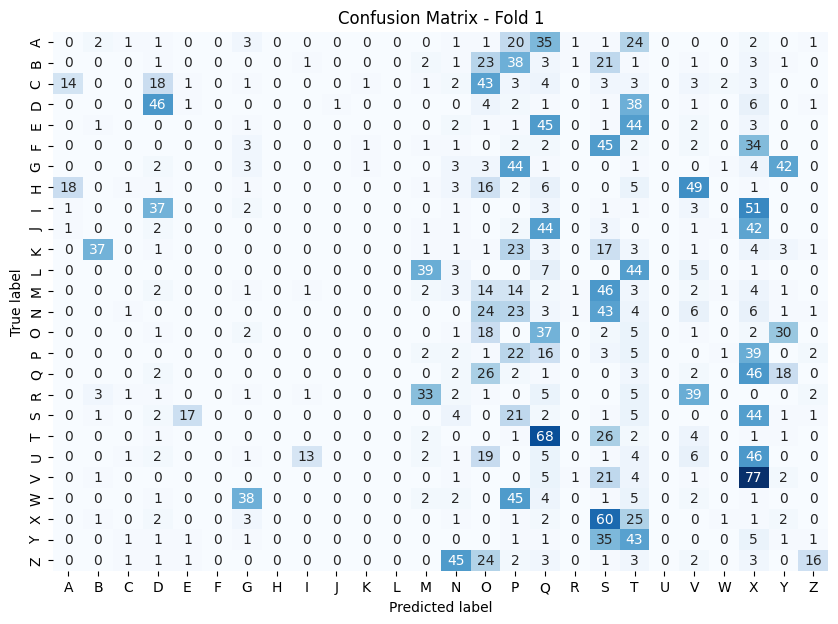

Fold 2/5
Epoch [1/20], Loss: 3.5119, Accuracy: 0.0479
Epoch [2/20], Loss: 3.5097, Accuracy: 0.0433
Epoch [3/20], Loss: 3.5120, Accuracy: 0.0445
Epoch [4/20], Loss: 3.5103, Accuracy: 0.0472
Epoch [5/20], Loss: 3.5095, Accuracy: 0.0439
Epoch [6/20], Loss: 3.5156, Accuracy: 0.0466
Epoch [7/20], Loss: 3.5024, Accuracy: 0.0455
Epoch [8/20], Loss: 3.5143, Accuracy: 0.0435
Epoch [9/20], Loss: 3.5150, Accuracy: 0.0449
Epoch [10/20], Loss: 3.5117, Accuracy: 0.0426
Epoch [11/20], Loss: 3.5131, Accuracy: 0.0461
Epoch [12/20], Loss: 3.5108, Accuracy: 0.0473
Epoch [13/20], Loss: 3.5113, Accuracy: 0.0457
Epoch [14/20], Loss: 3.5106, Accuracy: 0.0450
Epoch [15/20], Loss: 3.5086, Accuracy: 0.0441
Epoch [16/20], Loss: 3.5068, Accuracy: 0.0453
Epoch [17/20], Loss: 3.5132, Accuracy: 0.0479
Epoch [18/20], Loss: 3.5091, Accuracy: 0.0453
Epoch [19/20], Loss: 3.5121, Accuracy: 0.0434
Epoch [20/20], Loss: 3.5082, Accuracy: 0.0428


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 3.5658, Validation Accuracy: 0.0458
Validation Precision: 0.0332
Validation Recall: 0.0458
Validation F1 Score: 0.0345
Confusion Matrix:
[[ 0  0  0  0  0  1  0  0 18  0  0  0  1  4  0 15 42  0  3  4  0  0  1  1
   0  0]
 [ 0  0  0  2  1  0  1  0  0  0  0  0  0  2 26 39  8  1 18  3  0  2  1  1
   0  2]
 [26  0  0 17  0  0  3  0  0  0  0  0  1  0 34  1  0  0  2  2  0  0  0  3
   0  0]
 [ 0  0  1 48  0  0  0  0  0  1  0  0  0  4  1  0  5  0  1 15  0  1  0  4
   0 19]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  2  3  1 44  0  1 50  0  3  0  3
   0  1]
 [ 0  2  0  0  0  0  1  0  0  0  0  0  0  3  0  2  1  0 39  2  0  3  0 53
   0  2]
 [ 0  0  0  2  0  0  1  0  0  0  0  0  2  0 21  2 22  0  3 37  0  0  2  3
   1  0]
 [20  0  2  0  0  0  0  0  0  0  0  0  1  2 12  0 50  0  0  3  0  0  2  3
   0  0]
 [ 0  0  0 33  0  0  0  0  0  0  0  0  0 32  0  0  1  0  3  5  0  3  0  3
   2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1 50  0  2  2  0  1  1 48
   1  1]
 [ 0  0  2  1  0

<Figure size 640x480 with 0 Axes>

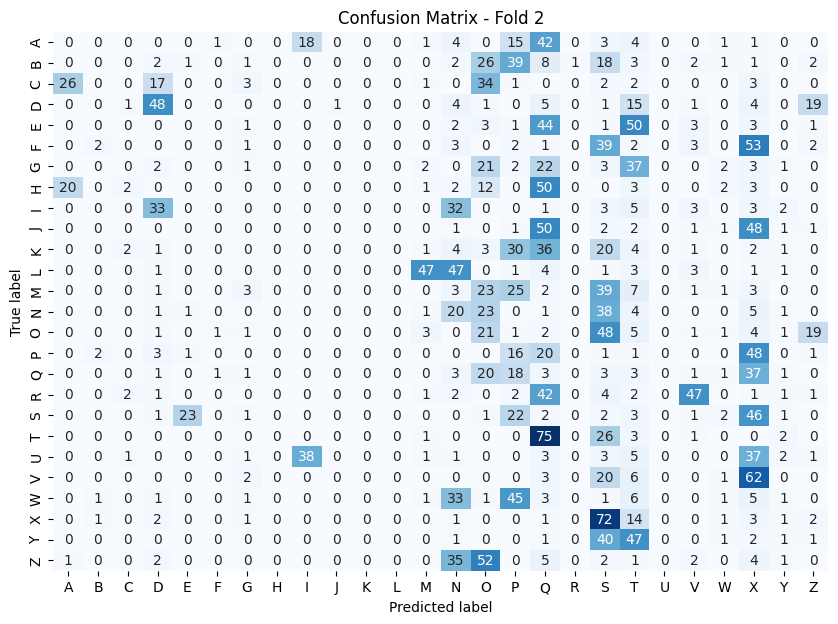

Fold 3/5
Epoch [1/20], Loss: 3.5213, Accuracy: 0.0423
Epoch [2/20], Loss: 3.5156, Accuracy: 0.0440
Epoch [3/20], Loss: 3.5219, Accuracy: 0.0416
Epoch [4/20], Loss: 3.5248, Accuracy: 0.0446
Epoch [5/20], Loss: 3.5155, Accuracy: 0.0475
Epoch [6/20], Loss: 3.5181, Accuracy: 0.0442
Epoch [7/20], Loss: 3.5176, Accuracy: 0.0469
Epoch [8/20], Loss: 3.5177, Accuracy: 0.0462
Epoch [9/20], Loss: 3.5229, Accuracy: 0.0465
Epoch [10/20], Loss: 3.5240, Accuracy: 0.0447
Epoch [11/20], Loss: 3.5271, Accuracy: 0.0423
Epoch [12/20], Loss: 3.5211, Accuracy: 0.0439
Epoch [13/20], Loss: 3.5268, Accuracy: 0.0428
Epoch [14/20], Loss: 3.5207, Accuracy: 0.0467
Epoch [15/20], Loss: 3.5164, Accuracy: 0.0456
Epoch [16/20], Loss: 3.5235, Accuracy: 0.0431
Epoch [17/20], Loss: 3.5258, Accuracy: 0.0432
Epoch [18/20], Loss: 3.5210, Accuracy: 0.0472
Epoch [19/20], Loss: 3.5214, Accuracy: 0.0418
Epoch [20/20], Loss: 3.5284, Accuracy: 0.0450


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 3.5279, Validation Accuracy: 0.0469
Validation Precision: 0.0361
Validation Recall: 0.0469
Validation F1 Score: 0.0294
Confusion Matrix:
[[ 0  0  1  3  0  0  2  0  0  0  0  0  0  3  0  2 46  0  3 35  0  0  0 21
   5  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  2 24 46  2  0 17  3  0  1  0  3
   0  0]
 [ 0  0  3 20  0  0  2  0  0  0  0  0  0  3 63  2  1  1  4  2  0  3  1  2
   0  0]
 [ 0  1  0  0  0  0  0  0  1  0  0  0  0  0 57  2  1  0  1  1  0  3 23  3
   1  0]
 [ 1  1  1  0  0  0 25  0  0  0  0  0  1  4  2  2 22  0  0 50  0  2  0  3
   1  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  2  4  0 19  2  0 20  0 46
   0  0]
 [ 0  0  0  2  1  0  0  0  0  0  0  0  0  1 23  1  0  1  1 33  0  1  0  2
  10  0]
 [13  0  1  1  0  0  2  0  0  0  0  0  1  3  9  3 39  0  1  4  0  1  0  0
   0  0]
 [ 0  2  0 54  0  0  0  0  0  0  0  0  0  0  0  1  3  0  0 54  0  1  1  3
   2  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  3  1  0 43  0  1  3  0  0  0 48
   0  0]
 [ 0  1  0  2  0

<Figure size 640x480 with 0 Axes>

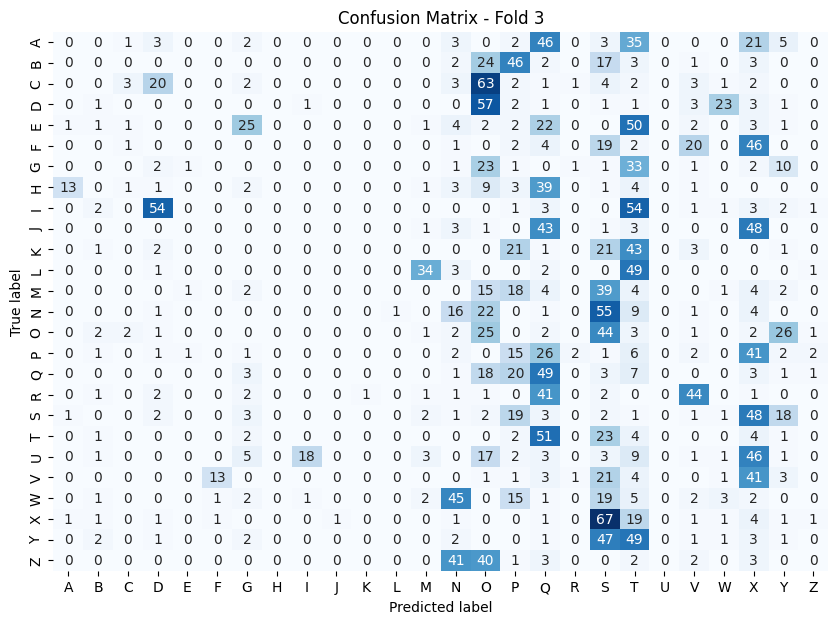

Fold 4/5
Epoch [1/20], Loss: 3.5140, Accuracy: 0.0441
Epoch [2/20], Loss: 3.5056, Accuracy: 0.0471
Epoch [3/20], Loss: 3.5099, Accuracy: 0.0445
Epoch [4/20], Loss: 3.5139, Accuracy: 0.0442
Epoch [5/20], Loss: 3.5105, Accuracy: 0.0453
Epoch [6/20], Loss: 3.5074, Accuracy: 0.0464
Epoch [7/20], Loss: 3.5113, Accuracy: 0.0457
Epoch [8/20], Loss: 3.5008, Accuracy: 0.0452
Epoch [9/20], Loss: 3.5092, Accuracy: 0.0445
Epoch [10/20], Loss: 3.5090, Accuracy: 0.0454
Epoch [11/20], Loss: 3.5083, Accuracy: 0.0440
Epoch [12/20], Loss: 3.5171, Accuracy: 0.0481
Epoch [13/20], Loss: 3.5067, Accuracy: 0.0446
Epoch [14/20], Loss: 3.5166, Accuracy: 0.0423
Epoch [15/20], Loss: 3.5080, Accuracy: 0.0451
Epoch [16/20], Loss: 3.5087, Accuracy: 0.0454
Epoch [17/20], Loss: 3.5168, Accuracy: 0.0450
Epoch [18/20], Loss: 3.5114, Accuracy: 0.0437
Epoch [19/20], Loss: 3.5112, Accuracy: 0.0457
Epoch [20/20], Loss: 3.5097, Accuracy: 0.0444


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 3.5872, Validation Accuracy: 0.0473
Validation Precision: 0.0476
Validation Recall: 0.0473
Validation F1 Score: 0.0380
Confusion Matrix:
[[ 0  0  1  0  0  0  0  0 19  1  0  0  0  3  0 18 56  1  3  3  0  0  1  2
   1  0]
 [ 1  1  0  2  0  0  5  0  0  0  0  0  0  1 25 41  2  0 21  2  0  0  1  2
   0  0]
 [ 0  0  0 23  0  0  2  0  0  0 17  0  2  3 32  2  4  0  0  1  0  2  2  3
   1  0]
 [ 1  1  1 29  1  1  0  0  0  0  0  0  0  4 21 18  5  0  3  0  0  3  1  1
   0  0]
 [ 0  1  0  1  0  0 19  0  0  0  1  0  1  1  1  0 22  0  0 32  0  2  2  4
   0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  2  6  0 47  1  0  3  0 44
   1  1]
 [39  0  0  2  1  0  1  0  0  0  0  0  2  1 31  3 19  0  7  2  0  3  1  2
   0  0]
 [23  1  1  0  1  0  1  0  0  0  0  0  3  0 20  0 50  0  1  3  0  3  0  3
   0  1]
 [ 0  1  0 36  0  0  1  0  0  0  0  0  1 40  0  1  1  0  0  8  0  3  0  4
   1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  2 43  0  0  2  0  1  0 44
   0  0]
 [ 0  2  1  2  0

<Figure size 640x480 with 0 Axes>

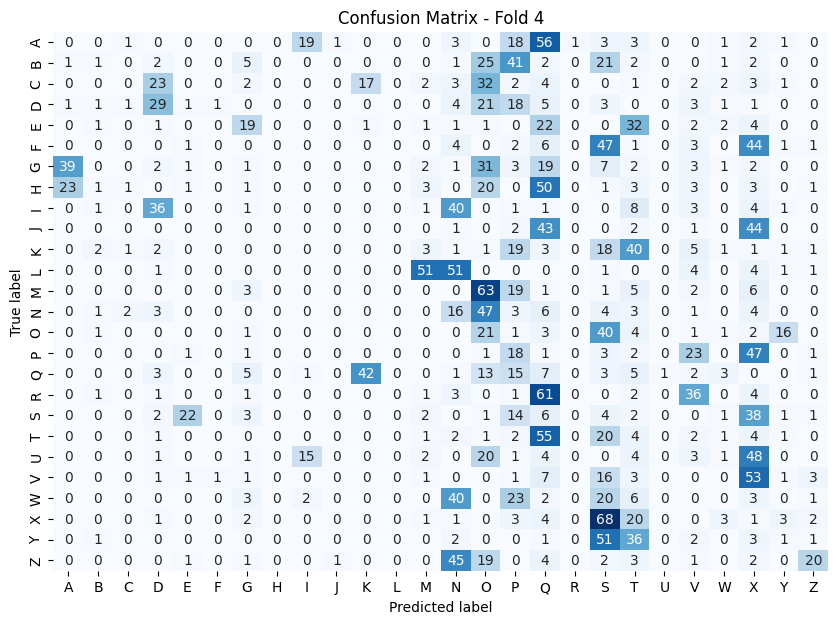

Fold 5/5
Epoch [1/20], Loss: 3.5225, Accuracy: 0.0424
Epoch [2/20], Loss: 3.5281, Accuracy: 0.0416
Epoch [3/20], Loss: 3.5145, Accuracy: 0.0430
Epoch [4/20], Loss: 3.5211, Accuracy: 0.0442
Epoch [5/20], Loss: 3.5176, Accuracy: 0.0460
Epoch [6/20], Loss: 3.5152, Accuracy: 0.0418
Epoch [7/20], Loss: 3.5186, Accuracy: 0.0453
Epoch [8/20], Loss: 3.5189, Accuracy: 0.0426
Epoch [9/20], Loss: 3.5191, Accuracy: 0.0460
Epoch [10/20], Loss: 3.5213, Accuracy: 0.0462
Epoch [11/20], Loss: 3.5180, Accuracy: 0.0446
Epoch [12/20], Loss: 3.5234, Accuracy: 0.0416
Epoch [13/20], Loss: 3.5178, Accuracy: 0.0473
Epoch [14/20], Loss: 3.5223, Accuracy: 0.0405
Epoch [15/20], Loss: 3.5227, Accuracy: 0.0413
Epoch [16/20], Loss: 3.5155, Accuracy: 0.0414
Epoch [17/20], Loss: 3.5208, Accuracy: 0.0441
Epoch [18/20], Loss: 3.5174, Accuracy: 0.0435
Epoch [19/20], Loss: 3.5252, Accuracy: 0.0460
Epoch [20/20], Loss: 3.5211, Accuracy: 0.0404


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 3.5118, Validation Accuracy: 0.0688
Validation Precision: 0.0356
Validation Recall: 0.0688
Validation F1 Score: 0.0437
Confusion Matrix:
[[ 0  0  0  1  0  2  2  0  0  0  0  0  0  1  0 14 40  0  2 24  0  0  1  0
   0  0]
 [ 0  0  0  1  1  0  0  0  1  0  0  0  0  2 18 37  7  1 16  2  0  4  0  4
   0  0]
 [23  0  0 25  0  0  0  0  0  0  0  0  1  1 41  4  2  0  3  1  0  1  1  4
   1  0]
 [ 0  1  0 56  0  1  0  0  1  0  0  0  2  1  1  0  3  0  2 39  0  2  0  2
   2  1]
 [ 0  0  0  0  1  0 25  0  0  0  0  0  0  1  0  0 16  0  0 37  0  1  0  5
   2  0]
 [ 0  3  1  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0 37  3  0  1  0 46
   1  0]
 [ 0  1  2  2  0  0  2  0  0  1  0  0  1  0  1 40 28  0  2  2  0  0  1  1
  25  0]
 [28  0  3  1  0  1  2  0  0  0  0  0  3  1 21  0  5  1  1  4  0  1  0  1
   0 39]
 [ 0  2  0 36  0  0  0  0  0  0  0  0  2  0  0  1  3  0  0 52  0  1  1  0
   1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0 41  0  0  5  0  0  0 53
   0  0]
 [ 0  0  0  1  0

<Figure size 640x480 with 0 Axes>

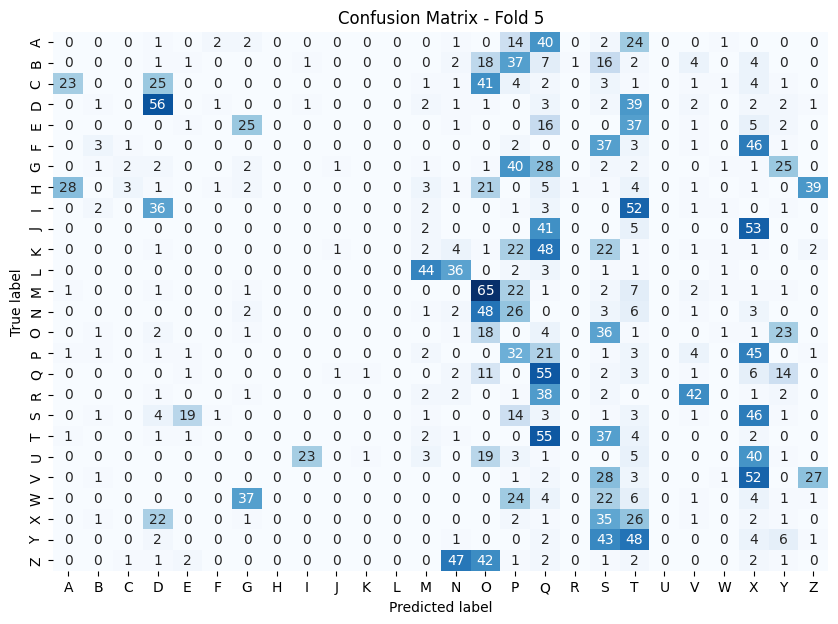

<Figure size 640x480 with 0 Axes>

In [21]:
# Loop a través de los pliegues
for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
    print(f'Fold {fold + 1}/{num_folds}')

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    # Crear DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Mover el modelo a la GPU
    model.to('cuda')

    train_losses = []
    train_accuracies = []

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to('cuda')  # Usa 'cuda' si tienes GPU
            labels = labels.to('cuda')  # Usa 'cuda' si tienes GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcula y registra la pérdida y la precisión
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_accuracy,
        })

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    # Calcula y muestra la pérdida y precisión de validación
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct / val_total

    # Calcular métricas adicionales
    precision = precision_score(val_labels, val_predictions, average='weighted')
    recall = recall_score(val_labels, val_predictions, average='weighted')
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    cm = confusion_matrix(val_labels, val_predictions)

    # Log métricas de validación a WandB
    wandb.log({
        "fold": fold + 1,
        "val_loss": val_epoch_loss,
        "val_accuracy": val_epoch_accuracy,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
    })

    # Imprimir métricas
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Guardar la figura
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.show()
    plt.clf()  # Limpiar la figura para la próxima iteración




In [22]:
# Finaliza la sesión de WandB
wandb.finish()

accuracy,▃▆▇▆█▅▇▇▃▃█▄▇▄▇▃▄▁█▄▄▄▅▃▇▇▄▆▅▄▂▅▃▆▂▄▅▆▄▃
epoch,▃▃▄▄▇▁▁▃▄▄▆▇▇▁▂▃▄▄▄▅▆▇▁▂▂▄▄▅▅▆██▁▁▃▄▆▆▇█
fold,▁▃▅▆█
loss,▄▅▇▃▅▅▄▃▂▄▃▃▂▂▆▆▇▆▇▇▆▄▁▂▄▅▁▄▂▄▂█▆▅▅▅▇▆▄▇
val_accuracy,▁▂▂▂█
val_f1,▅▃▁▅█
val_loss,▆▆▂█▁
val_precision,█▁▂▇▂
val_recall,▁▂▂▂█
accuracy,0.04038
epoch,20


In [24]:
model_save_path = f'model_letter_classifier_ResNet.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to model_letter_classifier_ResNet.pth
